In [1]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
from PIL import Image
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import faiss

def index_image_paths(folder):
    image_paths = []
    for synset in os.listdir(folder):
        subfolder = os.path.join(folder, synset)
        if os.path.isdir(subfolder):
            for image_name in os.listdir(subfolder):
                image_paths.append(os.path.join(subfolder, image_name))

    return np.array(image_paths)

def read_transcript(filename):
    with open(filename, 'r', encoding="utf-8") as transcript:
        return transcript.read()

SRC_DIR = r"..\Django\ground_truth_videography_project"

In [2]:
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"
print(device)
print(torch.cuda.get_device_name(0))

tokeniser = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

cuda
NVIDIA GeForce GTX 1650


In [3]:
filter = [516621, 653283, 589736, 630260, 590689, 516333, 701639, 538449, 558009, 1017551, 590174, 558027, 590157, 559003, 604023, 572346, 661681, 993150, 1018475, 792565, 1054980, 993647, 515930, 1279994, 1122816, 1122783, 1122318, 559453, 1122669, 1017594, 1122462, 558741, 558533, 559600, 1121668, 1121871, 1122352, 558838, 559166, 559573, 1122659, 1122602, 1147593, 590688, 766038, 589621, ]

image_paths = np.delete(index_image_paths(os.path.join(SRC_DIR, "imagenet-1k")), filter)
print(len(image_paths))

image_vectors = np.load(os.path.join(SRC_DIR, r"videography_pipeline\image_vectors\imagenet-1k-vecs-FILTERED.npy"))
print(image_vectors.shape)

1281121
(1281121, 512)


# FAISS - Efficient Similarity Searching

In [15]:
d = image_vectors.shape[1]
vecs = faiss.IndexFlatIP(d)
m = 8
nlist = 16384
nbits = 8
index = faiss.IndexIVFPQ(vecs, d, nlist, m, nbits)


index.train(image_vectors)
print(index.is_trained)

index.add(image_vectors)
print(index.ntotal)

faiss.write_index(index, fr"faiss_index\faiss_image_vecs_{nlist}")

True
1281121


In [ ]:
index = faiss.read_index(fr"faiss_index\faiss_image_vecs_{nlist}")

In [ ]:
prompt = "I'll be the light to guide you"
inputs = tokeniser(prompt, return_tensors="pt").to(device)
text_emb = model.get_text_features(**inputs)

text_emb = text_emb.cpu().detach().numpy()

scores = np.dot(text_emb, image_vectors.T)
print(scores)

best = np.argsort(-scores[0])[:10]
print(best)
for i in best:
    print(f"{image_paths[i]} ({i}): {scores[0][i]}")
    with Image.open(image_paths[i]) as image:
        plt.imshow(image, cmap='gray')
        plt.show()

# index.nprobe = 10
# k = 10
# dists, I = index.search(text_emb, k)
# print(I)

# for id, i in enumerate(I[0]):
#     print(f"{image_paths[i]} ({i}): {dists[0, id]}")
#     with Image.open(image_paths[i]) as image:
#         plt.imshow(image, cmap='gray')
#         plt.show()

# FAISS Analysis vs. Exhaustive Search

In [15]:
import pylrc

texts = []
for lrc in os.listdir('transcripts'):
    lyrics = pylrc.parse(read_transcript(rf'transcripts\{lrc}'))
    texts.extend([lyric.text for lyric in lyrics if lyric.text != '♪'])

print(len(texts))

399


## Exhaustive Search

In [ ]:
import time
import json

exhaustive = {
    'image_ids': [],
    'runtimes': [],
}
for text in texts:
    inputs = tokeniser(text, return_tensors="pt").to(device)
    text_emb = model.get_text_features(**inputs).cpu().detach().numpy()

    start = time.time()
    scores = np.dot(text_emb, image_vectors.T)
    best = np.argsort(-scores[0])[:10]
    end = time.time()

    exhaustive['image_ids'].append(best.tolist())
    exhaustive['runtimes'].append(end - start)

print(exhaustive['runtimes'])

In [ ]:
with open(r"faiss_analysis/exhaustive.json", "w", encoding='utf-8') as file:
    json.dump(exhaustive, file, ensure_ascii=False)

## FAISS Search

In [ ]:
import time
import json

faiss_res = {
    'image_ids': [],
    'runtimes': [],
}

nlist = 16384
index = faiss.read_index(fr"faiss_index\faiss_image_vecs_{nlist}")
index.nprobe = 10

for text in texts:
    inputs = tokeniser(text, return_tensors="pt").to(device)
    text_emb = model.get_text_features(**inputs).cpu().detach().numpy()

    start = time.time()
    dists, res = index.search(text_emb, 10)
    end = time.time()

    faiss_res['image_ids'].append(res[0].tolist())
    faiss_res['runtimes'].append(end - start)

print(faiss_res['runtimes'])

In [17]:
with open(fr"faiss_analysis/faiss_{nlist}.json", "w", encoding='utf-8') as file:
    json.dump(faiss_res, file, ensure_ascii=False)

## Analysis

In [4]:
import json

nlist = 16384
with open(r"faiss_analysis/exhaustive.json", "r", encoding='utf-8') as file:
    exhaustive = json.load(file)

with open(fr"faiss_analysis/faiss_{nlist}.json", "r", encoding='utf-8') as file:
    faiss_res = json.load(file)

exhaustive['image_ids'] = np.array(exhaustive['image_ids'])
exhaustive['runtimes'] = np.array(exhaustive['runtimes'])
faiss_res['image_ids'] = np.array(faiss_res['image_ids'])
faiss_res['runtimes'] = np.array(faiss_res['runtimes'])

In [5]:
print("MEAN RUNTIMES")
print(f"  Exhaustive Search: {exhaustive['runtimes'].mean():.4f}s")
print(f"  FAISS Search (nlist={nlist}): {faiss_res['runtimes'].mean():.4f}s")

print("\nTOTAL RUNTIMES")
print(f"  Exhaustive Search: {exhaustive['runtimes'].sum():.4f}s")
print(f"  FAISS Search (nlist={nlist}): {faiss_res['runtimes'].sum():.4f}s")

MEAN RUNTIMES
  Exhaustive Search: 0.2833s
  FAISS Search (nlist=16384): 0.0094s

TOTAL RUNTIMES
  Exhaustive Search: 113.0260s
  FAISS Search (nlist=16384): 3.7435s


In [6]:
def jaccard_sim(x, y):
    intersection = set(x).intersection(set(y))
    return len(intersection)/(len(x) + len(y) - len(intersection))

jaccard_similarities = np.array([jaccard_sim(a, b) for a in exhaustive['image_ids'] for b in faiss_res['image_ids']])
print(jaccard_similarities)
print(f"MAX JACCARD SIMILARITY: {jaccard_similarities.max()}")
print(f"MEAN JACCARD SIMILARITY: {jaccard_similarities.mean()}")

[0. 0. 0. ... 0. 0. 0.]
MAX JACCARD SIMILARITY: 0.0
MEAN JACCARD SIMILARITY: 0.0


I'll be the light to guide you


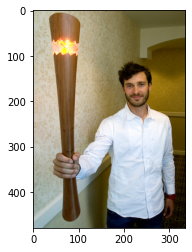

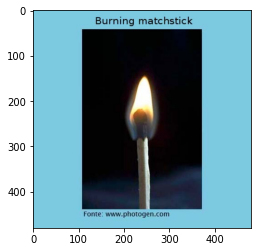

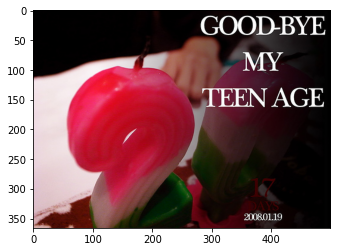

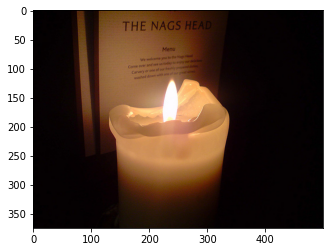

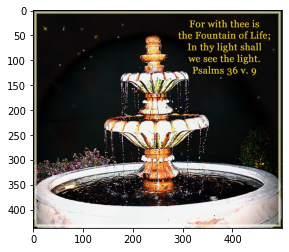

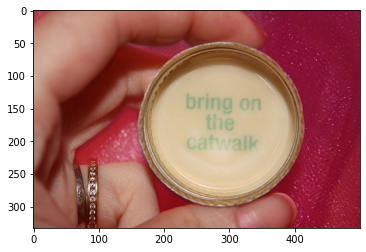

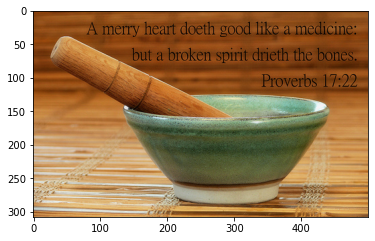

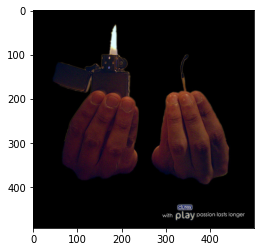

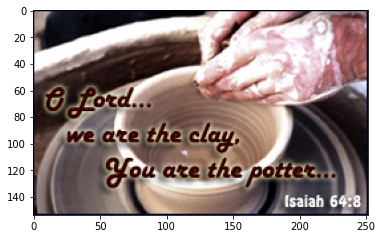

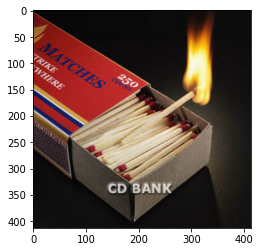

In [16]:
id = 150
print(texts[id])
for i in faiss_res['image_ids'][id]:
    with Image.open(image_paths[i]) as image:
        plt.imshow(image, cmap='gray')
        plt.show()

# Principle Component Analysis

Text(0.5, 1.0, 'Covariance Matrix of Subset of Image Vectors')

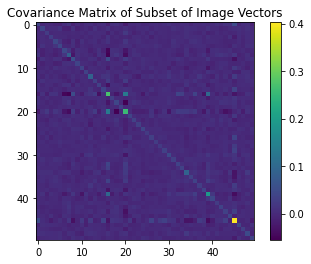

In [7]:
sigma = np.cov(image_vectors[:512], rowvar=False)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
img = ax.imshow(sigma[:50, :50])
fig.colorbar(img)
ax.set_title("Covariance Matrix of Subset of Image Vectors")

Text(0.5, 1.0, 'Eigenvectors of Covariance Matrix, Scaled by Eigenvalue')

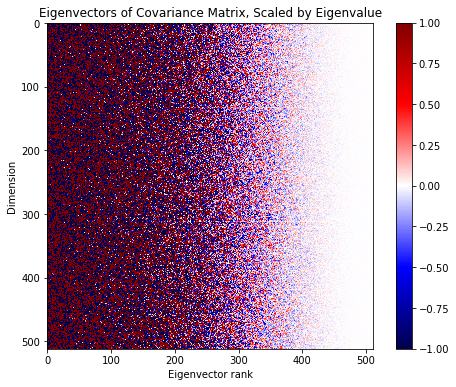

In [8]:
# compute eigendecomposition of A
evals, evecs = np.linalg.eigh(sigma)

# plot eigenvectors as an image, in order of decreasing eigenvalue
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)
order = np.argsort(-np.abs(evals))
img = ax.imshow(((evecs[:, order] * evals[order]*10000)), cmap='seismic', vmin=-1, vmax=1)
ax.set_xlabel("Eigenvector rank")
ax.set_ylabel("Dimension")
fig.colorbar(img)#, orientation='horizontal')
ax.set_title("Eigenvectors of Covariance Matrix, Scaled by Eigenvalue")

Text(0, 0.5, '$|\\lambda|$')

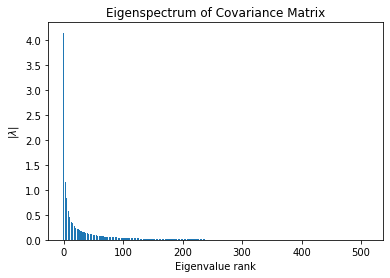

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.bar(np.arange(len(evals)), np.abs(evals[np.argsort(-np.abs(evals))]))
ax.set_title("Eigenspectrum of Covariance Matrix")
ax.set_xlabel("Eigenvalue rank")
ax.set_ylabel("$|\lambda|$")

Text(0.5, 1.0, 'Image vectors projected into 2D')

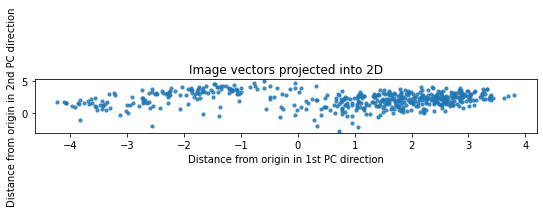

In [10]:
evals_sorted = evals[np.argsort(-np.abs(evals))]
evecs_sorted = evecs[:, np.argsort(-np.abs(evals))]

x = image_vectors[:512] @ evecs_sorted[:, 0]
y = image_vectors[:512] @ evecs_sorted[:, 1]

# Plot the dataset
fig = plt.figure(figsize=(9, 1))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y, c='C0', label="Original data", s=10, alpha=0.8)
ax.set_xlabel('Distance from origin in 1st PC direction')
ax.set_ylabel('Distance from origin in 2nd PC direction')
ax.set_title('Image vectors projected into 2D')

In [11]:
image_vecs_256 = image_vectors @ evecs_sorted[:256].T

[ 792403  923758  974561  662004 1048542  479162 1255434  331914  236380
  337334]
..\Django\ground_truth_videography_project\imagenet-1k\n03630383\n03630383_3439.JPEG (792403): 18.197527738190477


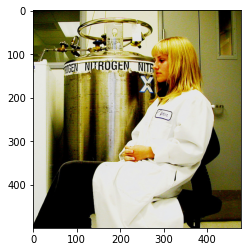

..\Django\ground_truth_videography_project\imagenet-1k\n03937543\n03937543_5213.JPEG (923758): 18.18420960383034


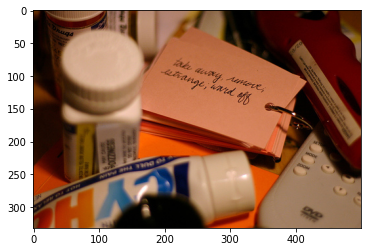

..\Django\ground_truth_videography_project\imagenet-1k\n04070727\n04070727_58656.JPEG (974561): 18.13569736458779


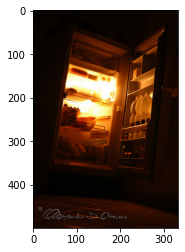

..\Django\ground_truth_videography_project\imagenet-1k\n03124170\n03124170_5078.JPEG (662004): 18.03697873526263


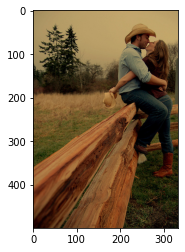

..\Django\ground_truth_videography_project\imagenet-1k\n04286575\n04286575_41032.JPEG (1048542): 17.98884944637461


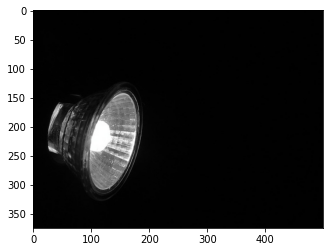

..\Django\ground_truth_videography_project\imagenet-1k\n02487347\n02487347_2845.JPEG (479162): 17.965809078295955


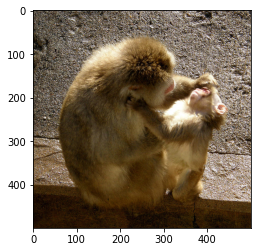

..\Django\ground_truth_videography_project\imagenet-1k\n09472597\n09472597_21421.JPEG (1255434): 17.949530172157225


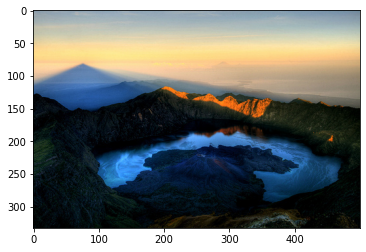

..\Django\ground_truth_videography_project\imagenet-1k\n02112018\n02112018_5441.JPEG (331914): 17.862321675415693


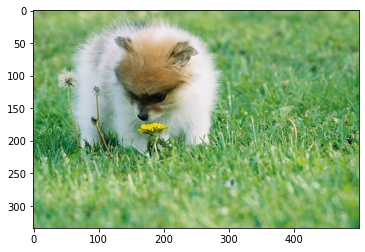

..\Django\ground_truth_videography_project\imagenet-1k\n02093991\n02093991_8023.JPEG (236380): 17.742844353940395


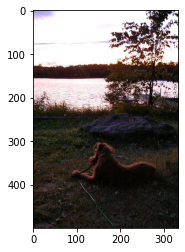

..\Django\ground_truth_videography_project\imagenet-1k\n02113023\n02113023_8773.JPEG (337334): 17.727666915701768


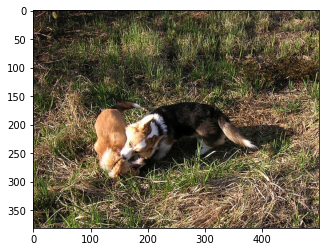

In [12]:
prompt = "I'll be the light to guide you"
inputs = tokeniser(prompt, return_tensors="pt").to(device)
text_emb = model.get_text_features(**inputs)

text_emb = text_emb.cpu().detach().numpy() @ evecs_sorted[:256].T

scores = np.dot(text_emb, image_vecs_256.T)

best = np.argsort(-scores[0])[:10]
print(best)
for i in best:
    print(f"{image_paths[i]} ({i}): {scores[0][i]}")
    with Image.open(image_paths[i]) as image:
        plt.imshow(image, cmap='gray')
        plt.show()